### MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### IMPORT

In [ ]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

In [ ]:
os.system("pip install transformers")
pass

In [ ]:
from transformers import BertTokenizer, BertModel

### CONSTANTS

In [ ]:
PROJECT_DIR = "/content/drive/MyDrive/SNAMA"

DATA_PATH = os.path.join(PROJECT_DIR, "data")
CHECKPOINTS_PATH = os.path.join(PROJECT_DIR, "checkpoints")
MODELS_PATH = os.path.join(PROJECT_DIR, "models")

PREPROCESSED_DATASET_NAME = "amazon_reviews_preprocessed.pckl"
PREPROCESSED_LABELS_NAME = "amazon_reviews_preprocessed_labels.pckl"

MODEL_HASHES_DATASET_NAME = "amazon_reviews_bert_hashes.pckl"

In [ ]:
RANDOM_STATE = 0xd
TEST_SIZE = 0.3

In [ ]:
BERT_FEATURES = 768
NUM_CLASSES = 0x3

In [ ]:
__LOGICAL_CORES__ = 0x4

In [ ]:
__DEVICE__ = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
__HASHES_FOUND__ = os.path.exists(os.path.join(DATA_PATH, MODEL_HASHES_DATASET_NAME))

### IO

In [ ]:
def dump_object(data, file, directory):
    with open(os.path.join(directory, file), 'wb') as file:
        pickle.dump(data, file)


def load_object(file, directory):
    with open(os.path.join(directory, file), 'rb') as file:
        data = pickle.load(file)
        return data


def exists_object(file, directory):
    return os.path.isfile(os.path.join(directory, file))


def dump_model(data, file, directory=MODELS_PATH):
    dump_object(data, file, directory)


def load_model(file, directory=MODELS_PATH):
    return load_object(file, directory)


def exists_model(file, directory=MODELS_PATH):
    return exists_object(file, directory)


def dump_checkpoint(data, file, directory=CHECKPOINTS_PATH):
    dump_object(data, file, directory)


def load_checkpoint(file, directory=CHECKPOINTS_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=CHECKPOINTS_PATH):
    return exists_object(file, directory)


def load_dataset_from_csv(file, directory=DATA_PATH):
    dataframe_ = pd.read_csv(os.path.join(directory, file))
    return dataframe_.Text.values, dataframe_.Score.values


def dump_dataset(data, file, directory=DATA_PATH):
    dump_object(data, file, directory)


def load_dataset(file, directory=DATA_PATH):
    return load_object(file, directory)


def exists_checkpoint(file, directory=DATA_PATH):
    return exists_object(file, directory)

### PREPROCESSED DATA LOADING

In [ ]:
if not __HASHES_FOUND__:
    dataset = load_dataset(PREPROCESSED_DATASET_NAME)
    labels = load_dataset(PREPROCESSED_LABELS_NAME)

### MODEL DEFINITION

In [ ]:
if not __HASHES_FOUND__:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained("bert-base-uncased")

    for param in model.parameters():
        param.requires_grad = False

    model = model.cuda()

In [ ]:
if not __HASHES_FOUND__:
    print(model.config, "\n\n")
    print(tokenizer.pretrained_init_configuration)
    print(tokenizer.init_kwargs)

In [ ]:
class BertClassifier(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, features=BERT_FEATURES):
        super(BertClassifier, self).__init__()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=features, out_features=512, bias=True),
            nn.BatchNorm1d(512),
            nn.GELU(),
            nn.Dropout(p=0.3),

            nn.Linear(in_features=512, out_features=128, bias=True),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Linear(in_features=128, out_features=64, bias=True),
            nn.BatchNorm1d(64),
            nn.GELU(),

            nn.Linear(in_features=64, out_features=num_classes),
        )

    def forward(self, data):
        return self.classifier(data)

In [ ]:
classifier = BertClassifier(num_classes=NUM_CLASSES).to(__DEVICE__)

### COMPUTING DATASET HASHES

In [ ]:
if not __HASHES_FOUND__:
    hashes = []
    progress = '0'

    with torch.no_grad():
        for i in range(dataset.shape[0x0]):
            back = '\b' * len(progress)
            progress = str(i + 0x1)
            print(f"{back}{progress}", end="")
            data = tokenizer(dataset[i], truncation=True, return_tensors='pt').to(__DEVICE__)
            hashes.append(model(**data).pooler_output.cpu())
            del data
            torch.cuda.empty_cache()
    
    hashes_dataset = torch.stack(hashes).squeeze()
 
    dump_dataset(hashes_dataset, MODEL_HASHES_DATASET_NAME)

### HASHES LOADING

In [ ]:
class TextDataset(Dataset):

    def __init__(self, dataset_, labels_):
        if len(dataset_) != len(labels_):
            raise Exception("Mismatching Lens")

        self.dataset = dataset_
        self.labels = labels_
 

    def __len__(self):
        return len(self.dataset)

    
    def __getitem__(self, index):
        return (self.dataset[index], self.labels[index])

In [ ]:
hashes_dataset = load_dataset(MODEL_HASHES_DATASET_NAME)
labels = load_dataset(PREPROCESSED_LABELS_NAME)

In [ ]:
training_set, test_set, training_labels, test_labels = train_test_split(hashes_dataset,
                                                                        labels,
                                                                        test_size=TEST_SIZE,
                                                                        random_state=RANDOM_STATE)

In [ ]:
test_labels = torch.tensor(test_labels)

In [ ]:
training_dataset = TextDataset(training_set, training_labels)

In [ ]:
training_loader = DataLoader(dataset=training_dataset,
                             batch_size=0x40,
                             shuffle=True)

### OPTIMIZER & LOSS

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()

In [ ]:
adam = torch.optim.Adam(classifier.parameters(), 
                        lr=2e-3)

### TRAINING

In [ ]:
def train(model, criterion, optimizer, loader, epochs, device=__DEVICE__):
    total_steps = len(loader)
    loss = 0.0
    min_loss = 0xffffffff
    
    best_weighs = None

    info = ""
    for epoch in range(1, epochs + 1):
        print("Epoch [{}/{}], Loss: {:1.4f}".format(epoch, epochs, loss))

        for batch_idx, (batch_data, batch_labels) in enumerate(loader):  
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            output = model(batch_data)

            loss = criterion(output, batch_labels)

            loss.backward()
            
            optimizer.step()
            if (batch_idx ) % 10 == 0:
                blanks = "\b" * (len(info))
                info = '\tStep [{}/{}], Loss: {:.4f}'.format(batch_idx, total_steps, loss.item())
                print("{}{}".format(blanks, info), end="")    
        
        if loss < min_loss:
            min_loss = loss
            best_weighs = model.state_dict()

        info = ""
        print("")

    return best_weighs

In [ ]:
best_params_50e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 1.2477	Step [10/2095], Loss: 1.0119	Step [20/2095], Loss: 1.0351	Step [30/2095], Loss: 0.8817	Step [40/2095], Loss: 0.9804	Step [50/2095], Loss: 1.0831	Step [60/2095], Loss: 0.8985	Step [70/2095], Loss: 0.9592	Step [80/2095], Loss: 1.0432	Step [90/2095], Loss: 0.8597	Step [100/2095], Loss: 0.8909	Step [110/2095], Loss: 1.0248	Step [120/2095], Loss: 0.9802	Step [130/2095], Loss: 0.8195	Step [140/2095], Loss: 0.9406	Step [150/2095], Loss: 0.8243	Step [160/2095], Loss: 0.8313

In [ ]:
best_params_100e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.6058	Step [10/2095], Loss: 0.5342	Step [20/2095], Loss: 0.6171	Step [30/2095], Loss: 0.5380	Step [40/2095], Loss: 0.6093	Step [50/2095], Loss: 0.5081	Step [60/2095], Loss: 0.6176	Step [70/2095], Loss: 0.5921	Step [80/2095], Loss: 0.4276	Step [90/2095], Loss: 0.6245	Step [100/2095], Loss: 0.7424	Step [110/2095], Loss: 0.6429	Step [120/2095], Loss: 0.5670	Step [130/2095], Loss: 0.5394	Step [140/2095], Loss: 0.4715	Step [150/2095], Loss: 0.5493	Step [160/2095], Loss: 0.7217

In [ ]:
best_params_150e = train(classifier, cross_entropy_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.4340	Step [10/2095], Loss: 0.4316	Step [20/2095], Loss: 0.3570	Step [30/2095], Loss: 0.4719	Step [40/2095], Loss: 0.4680	Step [50/2095], Loss: 0.6064	Step [60/2095], Loss: 0.3557	Step [70/2095], Loss: 0.3781	Step [80/2095], Loss: 0.4467	Step [90/2095], Loss: 0.5964	Step [100/2095], Loss: 0.5455	Step [110/2095], Loss: 0.3831	Step [120/2095], Loss: 0.3680	Step [130/2095], Loss: 0.4679	Step [140/2095], Loss: 0.3829	Step [150/2095], Loss: 0.5513	Step [160/2095], Loss: 0.3610

In [ ]:
checkpoint = classifier.state_dict()

### TEST

In [ ]:
def compute_accuracy(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim=0x1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim=0x1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
params = [best_params_50e, best_params_100e, best_params_150e]

with torch.no_grad():
    for i, param in enumerate(params):
        classifier.load_state_dict(param)
        test_pred = classifier(test_set.to(__DEVICE__)).cpu()
        acc = compute_accuracy(test_pred, test_labels)
        print("Checkpoint @{} epochs: {} accuracy".format((i + 0x1) * 50, acc))

Checkpoint @50 epochs: 70.0 accuracy
Checkpoint @100 epochs: 70.0 accuracy
Checkpoint @150 epochs: 70.0 accuracy


In [ ]:
__DUMP_WEIGHTS__ = False
if __DUMP_WEIGHTS__:
    torch.save(classifier.state_dict(), os.path.join(MODELS_PATH, "bert_clf_150e_70a.pth"))

### PLOTS

In [ ]:
def plot_confusion_matrix(torch_model, data, true_labels, model_name, device=__DEVICE__):
    y_pred_softmax = torch.log_softmax(classifier(data.to(device)), dim=0x1)
    _, y_pred = torch.max(y_pred_softmax, dim=0x1)
    y_pred = y_pred.cpu()
    accuracy = accuracy_score(test_labels, y_pred)
    raw_confusion_matrix = confusion_matrix(test_labels, y_pred)
    display = ConfusionMatrixDisplay(raw_confusion_matrix, display_labels=np.unique(test_labels)).plot(cmap="Blues")
    display.ax_.set_title(f"{model_name} Confusion Matrix (Accuracy: {np.round(accuracy, 0x2)})")
    plt.show()

In [ ]:
classifier.load_state_dict(torch.load(os.path.join(MODELS_PATH, "bert_clf_150e_70a.pth")))

<All keys matched successfully>

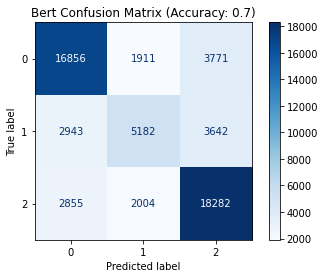

In [ ]:
plot_confusion_matrix(classifier, test_set, test_labels, "Bert")

### WEIGHTED LOSS

In [ ]:
ins = (1.0 / torch.tensor([np.sum(training_labels == i) for i in range(NUM_CLASSES)])).to(__DEVICE__)

In [ ]:
classifier = BertClassifier(num_classes=NUM_CLASSES).to(__DEVICE__)

In [ ]:
cross_entropy_weighted_loss = nn.CrossEntropyLoss(weight=ins)

In [ ]:
adam = torch.optim.Adam(classifier.parameters(), 
                        lr=2e-3)

### TRAINING WEIGHTED

In [ ]:
best_weighted_params_50e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 1.1780	Step [10/2095], Loss: 1.0895	Step [20/2095], Loss: 1.0674	Step [30/2095], Loss: 1.1077	Step [40/2095], Loss: 1.0091	Step [50/2095], Loss: 1.0065	Step [60/2095], Loss: 1.0305	Step [70/2095], Loss: 0.9253	Step [80/2095], Loss: 0.9378	Step [90/2095], Loss: 0.9799	Step [100/2095], Loss: 0.9256	Step [110/2095], Loss: 1.0314	Step [120/2095], Loss: 1.0631	Step [130/2095], Loss: 0.9615	Step [140/2095], Loss: 0.9865	Step [150/2095], Loss: 0.9560	Step [160/2095], Loss: 0.9764

In [ ]:
best_weighted_params_100e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.5755	Step [10/2095], Loss: 0.7690	Step [20/2095], Loss: 0.6307	Step [30/2095], Loss: 0.8007	Step [40/2095], Loss: 0.6443	Step [50/2095], Loss: 0.5575	Step [60/2095], Loss: 0.5813	Step [70/2095], Loss: 0.6109	Step [80/2095], Loss: 0.7934	Step [90/2095], Loss: 0.6063	Step [100/2095], Loss: 0.6084	Step [110/2095], Loss: 0.5754	Step [120/2095], Loss: 0.6594	Step [130/2095], Loss: 0.7165	Step [140/2095], Loss: 0.6168	Step [150/2095], Loss: 0.6969	Step [160/2095], Loss: 0.6845

In [ ]:
best_weighted_params_150e = train(classifier, cross_entropy_weighted_loss, adam, training_loader, 50)

Epoch [1/50], Loss: 0.0000
	Step [0/2095], Loss: 0.3325	Step [10/2095], Loss: 0.4680	Step [20/2095], Loss: 0.3897	Step [30/2095], Loss: 0.5239	Step [40/2095], Loss: 0.3774	Step [50/2095], Loss: 0.5129	Step [60/2095], Loss: 0.4604	Step [70/2095], Loss: 0.5175	Step [80/2095], Loss: 0.3749	Step [90/2095], Loss: 0.3321	Step [100/2095], Loss: 0.5540	Step [110/2095], Loss: 0.6217	Step [120/2095], Loss: 0.3786	Step [130/2095], Loss: 0.4879	Step [140/2095], Loss: 0.4622	Step [150/2095], Loss: 0.4557	Step [160/2095], Loss: 0.3353

### TEST WEIGHTED

In [ ]:
params = [best_weighted_params_50e, best_weighted_params_100e, best_weighted_params_150e]

with torch.no_grad():
    for i, param in enumerate(params):
        classifier.load_state_dict(param)
        test_pred = classifier(test_set.to(__DEVICE__)).cpu()
        acc = compute_accuracy(test_pred, test_labels)
        print("Checkpoint @{} epochs: {} accuracy".format((i + 0x1) * 50, acc))

Checkpoint @50 epochs: 69.0 accuracy
Checkpoint @100 epochs: 68.0 accuracy
Checkpoint @150 epochs: 69.0 accuracy


In [ ]:
__DUMP_WEIGHTS__ = False
if __DUMP_WEIGHTS__:
    torch.save(classifier.state_dict(), os.path.join(MODELS_PATH, "bert_clf_weighted_150e_69a.pth"))

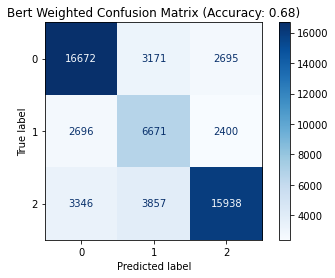

In [ ]:
plot_confusion_matrix(classifier, test_set, test_labels, "Bert Weighted")